In [1]:
import googlemaps
import geojsoncontour
import numpy as np
import pandas as pd
import geopandas as gpd
import random
import shapefile
import shapely
from shapely import geometry

from datetime import datetime, timedelta
from scipy import interpolate
import scipy as sp
import scipy.ndimage

from matplotlib import pyplot as plt 
from matplotlib import cm
import json
import os
import time
import folium
import folium.plugins
pd.set_option('display.max_columns', 500)

## KDTree

This lets us lookup values in a dataframe to find nearest neighbor etc will help in doing pricing stats eventually

In [2]:
class KDTree:
    def __init__(self, df, lat="LATITUDE", long="LONGITUDE"):
        self._df = df
        self._lat = lat
        self._long = long
        self._kd = sp.spatial.cKDTree(list(zip(df[self._lat], df[self._long])))
        
        
    def nearestk(self, lat, long, k=1):
        ds, idxs = self._kd.query([lat, long], k=k)
        return self._df.iloc[idxs]
    
    def nearestr(self, lat, long, r=(.02**.5)/69): # should be ~.1 miles est
        idxs = self._kd.query_ball_point([lat, long], r=r)
        return self._df.iloc[idxs]

        

In [3]:
conf = json.load(open("config.json"))

# Settings

In [4]:
FORHOME = datetime(2020, 2, 12, *conf["forhome"])
FORWORK = datetime(2020, 2, 12, *conf["forwork"])
WORKADDY = conf["work_address"]
ADAPTIVE = False
MIN_SALE_DATE = "2017-1-1"

N_POINTS = 500

gmaps = googlemaps.Client(key=conf["gmap_key"])

dc_shapefile = shapefile.Reader("Washington_DC_Boundary.shp")
dc_shape = dc_shapefile.shapes()[0]
dc_geometry = geometry.shape(dc_shape)


last_gmap = time.time()

# Address DB
This includes pricing from recent sales

In [5]:
add_df = pd.read_csv("Address_Points.csv")
add_df = add_df[["SSL", "SQUARE", "LATITUDE", "LONGITUDE", "FULLADDRESS", "ZIPCODE"]]
add_df = add_df[~add_df.FULLADDRESS.isna()]
add_kd = KDTree(add_df)


cama_df = pd.read_csv("Computer_Assisted_Mass_Appraisal__Residential.csv")
cama_df.SSL.describe()


res_df = cama_df.join(other=add_df.set_index("SSL"), on="SSL")
res_df.SALEDATE = pd.to_datetime(res_df.SALEDATE)
res_df = gpd.GeoDataFrame(res_df, geometry=gpd.points_from_xy(res_df.LONGITUDE, res_df.LATITUDE))


cur_res_df = res_df[res_df.SALEDATE >= pd.to_datetime(MIN_SALE_DATE, utc=True)]
cur_red_kd = KDTree(cur_res_df)

/Users/pbutler/.virtualenvs/dchousing/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# TODO:  Merge d_matrix and get_times to produce a df
def d_matrix(origins, destinations, leavetime):
    m = gmaps.distance_matrix(origins=origins, destinations=destinations,
                                      mode='driving', units='imperial', departure_time=leavetime,
                                      traffic_model='best_guess')
    time.sleep(5)
    return m

In [7]:
def gen_points(n):
    minx, miny, maxx, maxy = dc_shape.bbox
    locations = []
    while len(locations) < n:
        pnt = geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if dc_geometry.contains(pnt):
            address = add_kd.nearestk(pnt.y, pnt.x)
            address = "{} {}".format(address.FULLADDRESS, address.ZIPCODE)
            locations.append((pnt, address))
            
    return pd.DataFrame({
        "LATITUDE": [location.y for location, _ in locations],
        "LONGITUDE": [location.x for location, _ in locations],
        "ADDRESS": [address for _, address in locations]
    })

In [8]:
def divide_chunks(l, n=100): 
    for i in range(0, len(l), n):  
        yield l[i:i + n]
        
def get_times(drive_times):
    times = []
    for drive_time in drive_times: 
        for row in drive_time['rows']:
            data = row['elements']
            for elem in data:
                try:
                    times.append(elem['duration_in_traffic']['value']/60)
                except:
                    pass
    return times

In [9]:
if not os.path.exists("times.csv"):    
    sample_points = gen_points(n=1000)  # use 1000 pts to interpolate a grid
    origins = list(sample_points.ADDRESS)
    destinations = [WORKADDY]
    
    # to work
    drive_times = [d_matrix(split_origin, destinations, FORWORK) for split_origin in divide_chunks(origins)]
    times = get_times(drive_times)
    sample_points["TO_WORK"] = times

    drive_times = [d_matrix(destinations, split_origin, FORHOME) for split_origin in divide_chunks(origins)]
    times = get_times(drive_times)
    sample_points["TO_HOME"] = times
    
    sample_points.to_csv("times.csv")
    
else:
    sample_points = pd.read_csv("times.csv")

In [10]:
if ADAPTIVE:
    import adaptive

    def get_address(lat, long):
        return (lat, long, add_kd.nearestk(lat, long).FULLADDRESS)

    def f(latlongs, long=None, leavetime=None, origin=None, dest=None):
        global last_gmap
        if long is not None:
            single = True
            latlongs = [(latlongs, long)]
        else:
            single = False

        dc_mask = [is_dc(long, lat) for lat, long in latlongs]
        dc_points = [(lat, long) for (lat, long), dc in zip(latlongs, dc_mask) if dc]
        notdc_points = [(lat, long) for (lat, long), dc in zip(latlongs, dc_mask) if not dc]
        dc_adds = ["{} {}".format(point.FULLADDRESS, point.ZIPCODE) for point in 
                    [add_kd.nearestk(lat, long, k=1) for lat, long in dc_points]]

        since = time.time() - last_gmap
        if since < 5:
            time.sleep(5 - since)

        #print([WORKADDY])
        #print(dc_adds)
        if origin is None:
            m = gmaps.distance_matrix(origins=dc_adds, destinations=[dest],
                                      mode='driving', units='imperial', departure_time=leavetime,
                                      traffic_model='best_guess')
        elif dest is None:
            m = gmaps.distance_matrix(origins=[origin], destinations=dc_adds,
                                      mode='driving', units='imperial', departure_time=leavetime,
                                      traffic_model='best_guess')        
        else:
            assert dest is not None or origin is not None

        last_gmap = time.time()

        times = get_times([m, ])
        retx = dc_points + notdc_points
        rety = times + ([np.nan] * len(notdc_points))
        if single:
            return rety[0]
        else:
            return retx, rety

    def f_work(*args, **kwargs):
        kwargs["leavetime"] = FORWORK
        kwargs["dest"] = WORKADDY
        return f(*args, **kwargs)

    def f_home(*args, **kwargs):
        kwargs["leavetime"] = FORHOME
        kwargs["origin"] = WORKADDY
        return f(*args, **kwargs)

    def f_total(*args):
        return f_work(*args) + f_home(*args)

    learner = adaptive.Learner2D(f_total, [[miny, maxy], [minx, maxx]])
    count = 0
    for i in range(10):
        pts,_ = learner.ask(100)
        pts, vals = f_work(pts)
        learner.tell_many(pts, vals)

In [11]:
# this is slow for n > 100 not entirely sure why
minx, miny, maxx, maxy = dc_shape.bbox
def is_dc(x, y):
    pnt = geometry.Point(x, y)
    return dc_geometry.contains(pnt)

if not os.path.exists("mask.npz"):
    bmask = [[is_dc(x, y) 
                 for x in np.linspace(minx, maxx, N_POINTS)]             
                 for y in np.linspace(miny, maxy, N_POINTS)] 
    mask = np.array(bmask, dtype=float)
    np.savez("mask.npz", mask=mask)
else:
    mask = np.load("mask.npz")["mask"]

In [12]:
def gen_ipoints(df, label="TO_WORK", n=N_POINTS):
    """generate interpolated points from a set of given points"""
    minx, miny, maxx, maxy = dc_shape.bbox
    x, y = np.linspace(minx, maxx, n), np.linspace(miny, maxy, n)
    xx, yy = np.meshgrid(x, y)
     
    points = df[["LONGITUDE", "LATITUDE"]].values
    points = df[["LATITUDE", "LONGITUDE"]].values
    return sp.interpolate.griddata(points, list(df[label]), (yy, xx), method="nearest")

def gen_ipoints_adap(data, label="TO_WORK", n=N_POINTS):
    """generate interpolated points from a set of given points"""
    minx, miny, maxx, maxy = dc_shape.bbox
    x, y = np.linspace(minx, maxx, n), np.linspace(miny, maxy, n)
    xx, yy = np.meshgrid(x, y)
    available_pts = [(x, y) for (x, y), v in data.items() if not np.isnan(v) and v < 120]
    available_data = [v for (x, y), v in data.items() if not np.isnan(v) and v < 120]
    return sp.interpolate.griddata(available_pts, available_data, (yy, xx), method="nearest")

def gen_contours(img, n=N_POINTS):
    minx, miny, maxx, maxy = dc_shape.bbox
    x, y = np.linspace(minx, maxx, n), np.linspace(miny, maxy, n)
    xx, yy = np.meshgrid(x, y)

    contour = plt.contour(xx, yy, img, levels=np.arange(0, 120, 5))
    
    
    geojson = geojsoncontour.contour_to_geojson(
        contour=contour,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1)
    return geojson


/Users/pbutler/.virtualenvs/dchousing/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


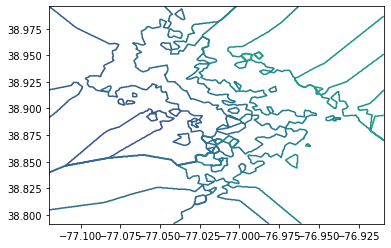

In [13]:

if not ADAPTIVE: 
    img = gen_ipoints(sample_points, "TO_WORK")
    img = np.minimum(img, sample_points["TO_WORK"].max())
    img = np.maximum(img, sample_points["TO_WORK"].min())
else:
    ### Adaptive data
    img = gen_ipoints_adap(learner.data)


contours = gen_contours(img)

img = img - np.nanmin(img)
img = img / np.nanmax(img)

#img = np.log(img)
# mask values we want off are zero, dividing by zero results in inf and we can adjust a colormap with that
img = img / mask  

#img = np.nan_to_num(img, 0)
img = img[::-1, :]

def cmap(x):
    mp = cm.get_cmap("jet")
    if np.isnan(x) or np.isinf(x):
        return (0, 0, 0, 0)
    else:
        return mp(x)

m = folium.Map(location=[38.9072,-77.0369], tiles='Stamen Toner', zoom_start=12)
minx, miny, maxx, maxy = dc_shape.bbox
folium.raster_layers.ImageOverlay(
    img, 
    bounds=[[miny, minx], [maxy, maxx]], 
    opacity=.75,
    colormap=cmap).add_to(m)
folium.GeoJson(
    contours,
    style_function=lambda f: {"color": "black", "weight": ".5" },
).add_to(m)
m.save("commute.html")
m